## Load libraries

In [1]:
import pandas as pd
import lightgbm as lgb

import matplotlib.pyplot as plt

%matplotlib inline

try:
    # To enable interactive mode you should install ipywidgets
    # https://github.com/jupyter-widgets/ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

## Load data

In [2]:
df_train = pd.read_csv('../../regression/regression.train', header=None, sep='\t')
df_test = pd.read_csv('../../regression/regression.test', header=None, sep='\t')

y_train = df_train[0]
y_test = df_test[0]
X_train = df_train.drop(0, axis=1)
X_test = df_test.drop(0, axis=1)

## Create Dataset object for LightGBM

In [3]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

## Configuration dictionary

In [4]:
params = {
    'num_leaves': 5,
    'metric': ['l1', 'l2'],
    'verbose': -1
}

## Training

In [5]:
evals_result = {}  # to record eval results for plotting
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
                feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                categorical_feature=[21],
                evals_result=evals_result,
                verbose_eval=10)

[10]	training's l1: 0.457448	training's l2: 0.217995	valid_1's l1: 0.456464	valid_1's l2: 0.21641
[20]	training's l1: 0.436869	training's l2: 0.205099	valid_1's l1: 0.434057	valid_1's l2: 0.201616
[30]	training's l1: 0.421302	training's l2: 0.197421	valid_1's l1: 0.417019	valid_1's l2: 0.192514
[40]	training's l1: 0.411107	training's l2: 0.192856	valid_1's l1: 0.406303	valid_1's l2: 0.187258
[50]	training's l1: 0.403695	training's l2: 0.189593	valid_1's l1: 0.398997	valid_1's l2: 0.183688
[60]	training's l1: 0.398704	training's l2: 0.187043	valid_1's l1: 0.393977	valid_1's l2: 0.181009
[70]	training's l1: 0.394876	training's l2: 0.184982	valid_1's l1: 0.389805	valid_1's l2: 0.178803
[80]	training's l1: 0.391147	training's l2: 0.1828	valid_1's l1: 0.386476	valid_1's l2: 0.176799
[90]	training's l1: 0.388101	training's l2: 0.180817	valid_1's l1: 0.384404	valid_1's l2: 0.175775
[100]	training's l1: 0.385174	training's l2: 0.179171	valid_1's l1: 0.382929	valid_1's l2: 0.175321


## Plot metrics recorded during training

In [6]:
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()

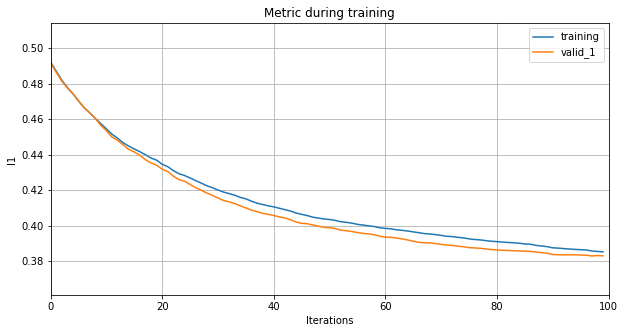

In [7]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=params['metric'])
else:
    render_metric(params['metric'][0])

## Plot feature importances

In [8]:
def render_plot_importance(importance_type, max_features=10,
                           ignore_zero=True, precision=4):
    ax = lgb.plot_importance(gbm, importance_type=importance_type,
                             max_num_features=max_features,
                             ignore_zero=ignore_zero, figsize=(12, 8),
                             precision=precision)
    plt.show()

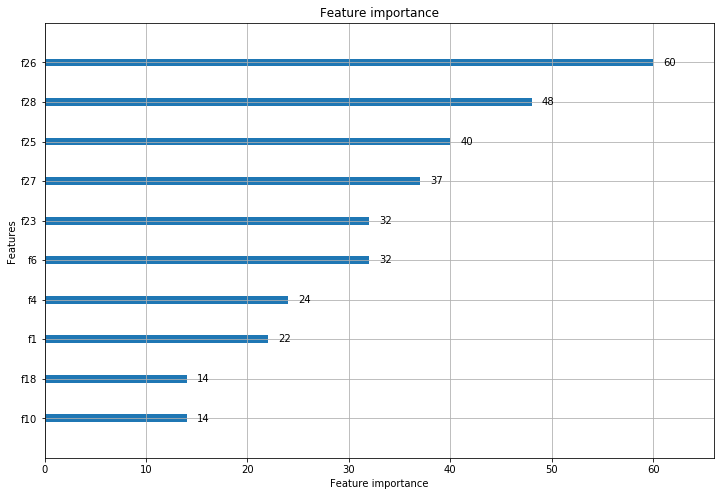

In [9]:
if INTERACTIVE:
    # create widget for interactive feature importance plot
    interact(render_plot_importance,
             importance_type=['split', 'gain'],
             max_features=(1, X_train.shape[-1]),
             precision=(0, 10))
else:
    render_plot_importance(importance_type='split')

## Plot split value histogram

In [10]:
def render_histogram(feature):
    ax = lgb.plot_split_value_histogram(gbm, feature=feature,
                                        bins='auto', figsize=(10, 5))
    plt.show()

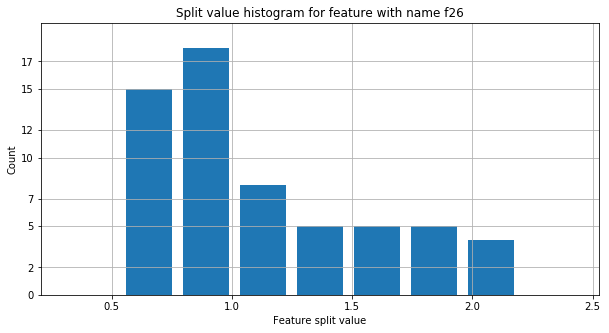

In [11]:
if INTERACTIVE:
    # create widget for interactive split value histogram
    interact(render_histogram,
             feature=gbm.feature_name())
else:
    render_histogram(feature='f26')

## Plot trees

In [10]:
def render_tree(tree_index, show_info, precision=4):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(gbm, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

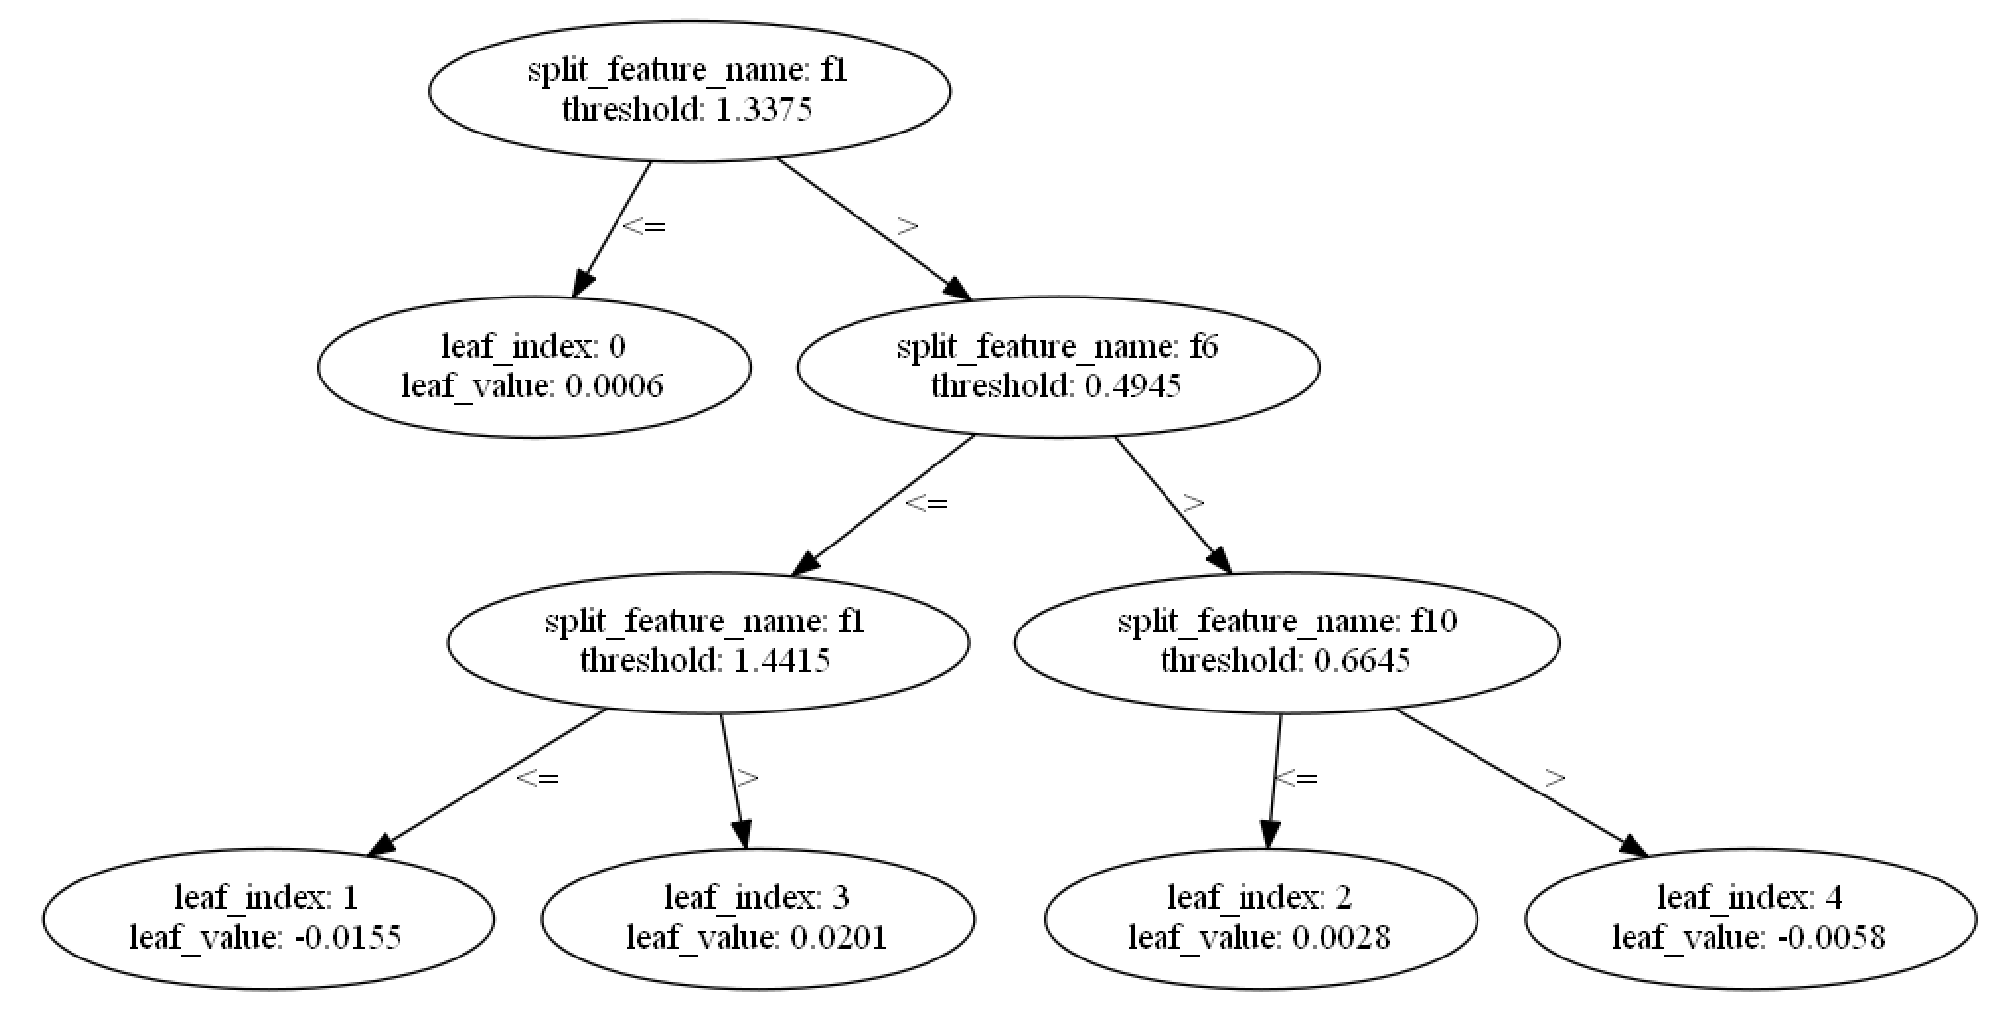

In [11]:
if INTERACTIVE:
    # create widget to switch between trees and control info in nodes
    interact(render_tree,
             tree_index=(0, gbm.num_trees() - 1),
             show_info=SelectMultiple(  # allow multiple values to be selected
                 options=['None',
                          'split_gain',
                          'internal_value',
                          'internal_count',
                          'internal_weight',
                          'leaf_count',
                          'leaf_weight'],
                 value=['None']),
             precision=(0, 10))
    tree = None
else:
    tree = render_tree(84, ['None'])
tree